In [51]:
# Word2vec is a two-layer neural net that processes text by “vectorizing” words.  Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus.  While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

# Word2vec’s applications extend beyond parsing sentences in the wild.  It can be applied just as well to genes, code, likes, playlists, social media graphs and other verbal or symbolic series in which patterns may be discerned.

# Why? Because words are simply discrete states like the other data mentioned above, and we are simply looking for the transitional probabilities between those states: the likelihood that they will co-occur. 
    
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


df = pd.read_csv('C:\\data.txt')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))


spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')



In [52]:

sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)


In [53]:

w2v_model.wv.most_similar(positive=['economy'])


[('economic', 0.9802016615867615),
 ('growth', 0.9340611696243286),
 ('rate', 0.9306743144989014),
 ('continue', 0.9282042980194092),
 ('interest', 0.9151568412780762),
 ('boost', 0.8815890550613403),
 ('low', 0.8754473924636841),
 ('strong', 0.8589886426925659),
 ('job', 0.842096209526062),
 ('rise', 0.8317513465881348)]

In [54]:

w2v_model.wv.most_similar(positive=['president'])


[('commission', 0.969780683517456),
 ('state', 0.9286476969718933),
 ('foreign', 0.8993659615516663),
 ('statement', 0.8988351821899414),
 ('financial', 0.8833909034729004),
 ('raise', 0.8752353191375732),
 ('official', 0.8713678121566772),
 ('agree', 0.8700740933418274),
 ('investment', 0.8511845469474792),
 ('fund', 0.8505107760429382)]

In [55]:


w2v_model.wv.similarity('company', 'business')



0.8695214

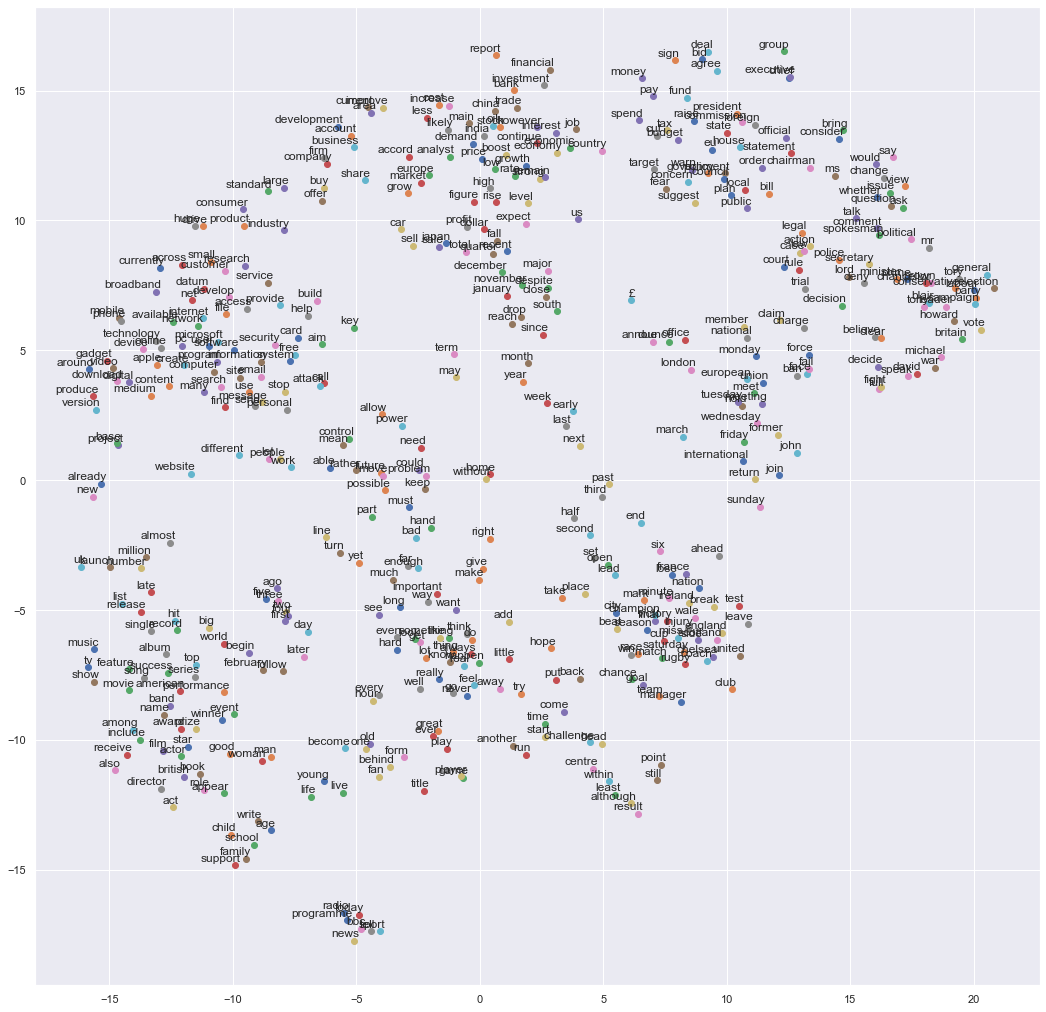

In [56]:

# Please note, the above results could change if we change min_count. For example, if we set min_count=100, we will have more words to work with, some of them may be more similar to the target words than the above results; If we set min_count=300, some of the above results may disappear.
#  We Use t-SNE to represent high-dimensional data in a lower-dimensional space.


def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
tsne_plot(w2v_model)


In [ ]:


# data:
# https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

